In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
import platform

In [10]:
# JSONL 파일 불러오기
file_path = '최종-상위n개/review_roberta.json'

data = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

# pandas DataFrame으로 변환
df = pd.DataFrame(data)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449116 entries, 0 to 449115
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   review_id    449116 non-null  object
 1   user_id      449116 non-null  object
 2   stars        449116 non-null  int64 
 3   business_id  449116 non-null  object
 4   sentiment    449116 non-null  object
dtypes: int64(1), object(4)
memory usage: 17.1+ MB


In [12]:
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = ['Times New Roman', 'Malgun Gothic']
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = ['Times New Roman', 'AppleGothic']
else:  # Linux or 기타
    plt.rcParams['font.family'] = ['Times New Roman', 'NanumGothic']

In [13]:
# 함수
# -------------------------------------

# 비율과 개수 표시 텍스트 생성
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count:,}건)'
    return my_autopct

# 색상 설정
colors_sentiment = {
    'positive': '#87CEEB',
    'neutral': '#98FB98',
    'negative': '#FFB6C1'
}
sentiment_order = ['positive', 'neutral', 'negative']

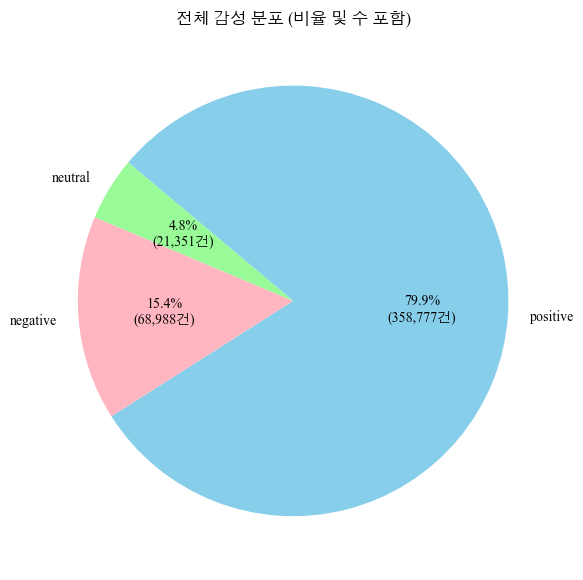

In [19]:
# -------------------------------------
# 전체 감성 분포

# 감성 값 개수 계산
sentiment_counts = df['sentiment'].value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values

# 감성별 색상 적용
colors = [colors_sentiment[label] for label in labels]

# 원형 차트 그리기
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct=make_autopct(sizes),
    startangle=140,
    counterclock=False
)
plt.title('전체 감성 분포 (비율 및 수 포함)')
plt.tight_layout()
plt.show()





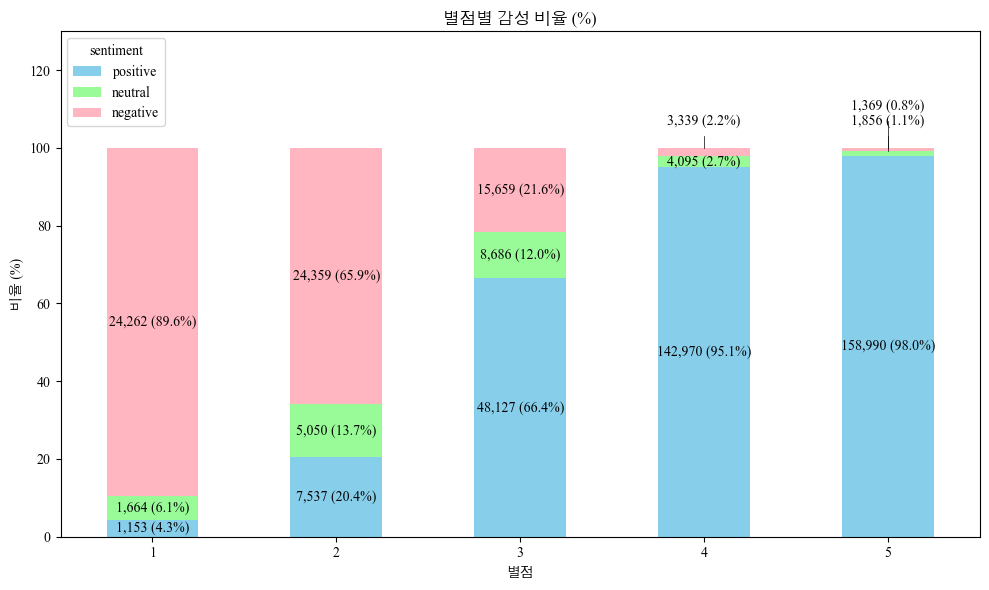

In [15]:
# -------------------------------------
# 별점별 감성 비율

import matplotlib.pyplot as plt

# 1. 별점-감성 조합 개수
stars_sentiment = df.groupby(['stars', 'sentiment']).size().unstack(fill_value=0)

# 2. 감성 비율 (0~100%)
stars_sentiment_ratio = stars_sentiment.div(stars_sentiment.sum(axis=1), axis=0) * 100

color_list = [colors_sentiment[s] for s in sentiment_order if s in stars_sentiment.columns]

# 4. 시각화
ax = stars_sentiment_ratio[sentiment_order].plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=color_list
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.title('별점별 감성 비율 (%)')
plt.xlabel('별점')
plt.ylabel('비율 (%)')
plt.ylim(0, 130)  # 더 넉넉한 위 공간 확보

# 5. 외부 표시 오프셋 저장용 딕셔너리
external_label_offsets = {i: 105 for i in range(len(stars_sentiment))}  # 각 x 좌표의 외부 시작 y 위치

# 6. 텍스트 및 선 표시
for i, (index, row) in enumerate(stars_sentiment.iterrows()):
    cum_height = 0
    for sentiment in sentiment_order:
        if sentiment in row:
            count = row[sentiment]
            percent = stars_sentiment_ratio.loc[index, sentiment]
            label = f'{count:,} ({percent:.1f}%)'

            if count == 0:
                continue

            if percent > 2.5:
                # 내부 표기
                ax.text(
                    i,
                    cum_height + percent / 2,
                    label,
                    ha='center',
                    va='center',
                    fontsize=10,
                    color='black'
                )
            else:
                # 외부 표기 + 라벨 오프셋 위치 계산
                offset_y = external_label_offsets[i]
                ax.plot([i, i], [cum_height + percent, offset_y - 2], color='black', linewidth=0.5)
                ax.text(
                    i,
                    offset_y,
                    label,
                    ha='center',
                    va='bottom',
                    fontsize=10,
                    color='black'
                )
                external_label_offsets[i] += 4 # 다음 라벨은 더 위에

            cum_height += percent

plt.tight_layout()
plt.show()




/var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/ipykernel_28688/4191248230.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('cool')  # 파랑-보라 계열 (시원한 느낌)


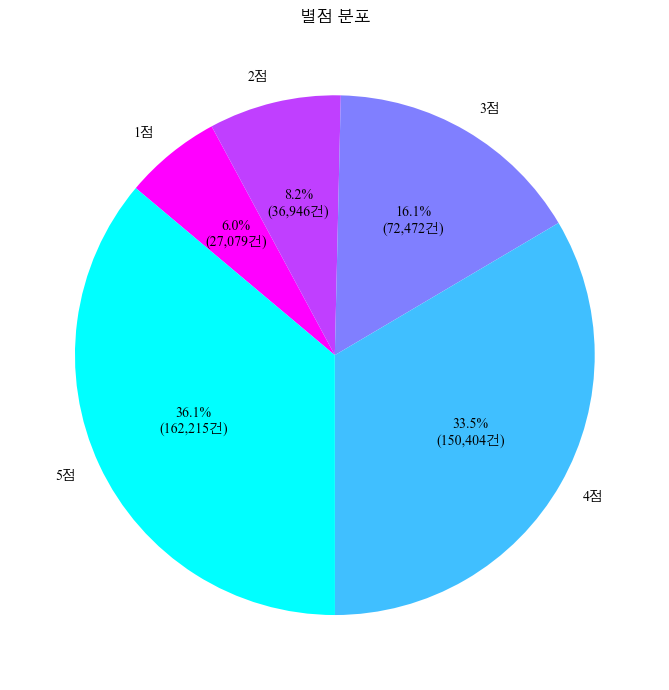

In [16]:
# -------------------------------------
# 별점 분포

# 1. 별점별 리뷰 수 계산
stars_counts = df['stars'].value_counts().sort_index()
labels = stars_counts.index
sizes = stars_counts.values

# 2. 색상 지정: 붉은색(1점) → 푸른색(5점) 그라데이션
cmap = cm.get_cmap('cool')  # 파랑-보라 계열 (시원한 느낌)
normalized = np.linspace(0, 1, len(labels))
colors = [cmap(1 - val) for val in normalized]  # 1점은 붉게, 5점은 푸르게 보이게 뒤집음

# 3. 원형 차트 시각화
plt.figure(figsize=(7, 7))
plt.pie(
    sizes,
    labels=[f'{star}점' for star in labels],
    colors=colors,
    autopct=make_autopct(sizes),
    startangle=140,
    counterclock=False
)
plt.title('별점 분포')
plt.tight_layout()
plt.show()


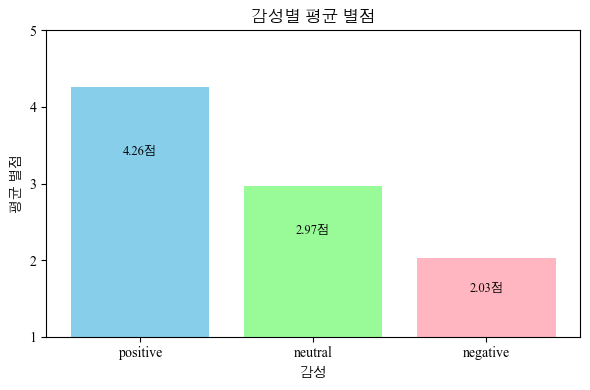

In [17]:
# -------------------------------------
# 감성별 평균 별점

# 1. 평균 별점 계산
avg_stars_by_sentiment = df.groupby('sentiment')['stars'].mean()

# 3. 시각화
plt.figure(figsize=(6, 4))
bars = plt.bar(
    sentiment_order,
    [avg_stars_by_sentiment[s] for s in sentiment_order],
    color=[colors_sentiment[s] for s in sentiment_order]
)

# 4. 막대 안쪽에 값 표시 (소수점 둘째자리)
for i, s in enumerate(sentiment_order):
    value = avg_stars_by_sentiment[s]
    plt.text(
        i,                       # x 위치
        value*0.8,              # y 위치 (막대 내부 중앙쯤)
        f'{value:.2f}점',         # 소수점 둘째자리
        ha='center',
        va='center',
        fontsize=9,
        color='black'
    )

# 5. y축 설정
plt.ylim(1, 5)
plt.yticks(range(1, 6, 1))  # 1단위 눈금

plt.title('감성별 평균 별점')
plt.xlabel('감성')
plt.ylabel('평균 별점')
plt.tight_layout()
plt.show()


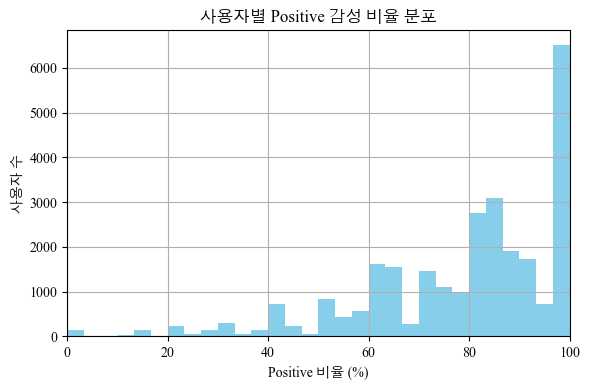

In [18]:
# -------------------------------------
# 사용자별 Positive 감성 비율

# 1. 사용자별 positive 비율 계산 (%)
user_sentiment_ratio = df.pivot_table(index='user_id', columns='sentiment', aggfunc='size', fill_value=0)
user_sentiment_ratio['positive_ratio'] = (
    user_sentiment_ratio['positive'] / user_sentiment_ratio.sum(axis=1)
) * 100  # %로 변환

# 2. 히스토그램 시각화
plt.figure(figsize=(6, 4))
user_sentiment_ratio['positive_ratio'].hist(bins=30, color='#87CEEB')
plt.title('사용자별 Positive 감성 비율 분포')
plt.xlabel('Positive 비율 (%)')
plt.ylabel('사용자 수')
plt.xlim(0, 100)  # ✅ 가로축 범위 고정
plt.tight_layout()
plt.show()
